# Variational QEPs w/ Multiple Outputs

## Introduction

In this example, we will demonstrate how to construct approximate/variational QEPs that can model vector-valued functions (e.g. multitask/multi-output QEPs).


In [1]:
import math
import torch
import qpytorch
import tqdm
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Set up training data

In the next cell, we set up the training data for this example. We'll be using 100 regularly spaced points on [0,1] which we evaluate the function on and add Gaussian noise to get the training labels.

We'll have four functions - all of which are some sort of sinusoid. Our `train_targets` will actually have two dimensions: with the second dimension corresponding to the different tasks.

In [2]:
train_x = torch.linspace(0, 1, 100)

train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.sin(train_x * (2 * math.pi)) + 2 * torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    -torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)

print(train_x.shape, train_y.shape)

torch.Size([100]) torch.Size([100, 4])


## Define a multitask model

We are going to construct a batch variational QEP - using a `CholeskyVariationalDistribution` and a `VariationalStrategy`. Each of the batch dimensions is going to correspond to one of the outputs. In addition, we will wrap the variational strategy to make the output appear as a `MultitaskMultivariateQExponential` distribution. Here are the changes that we'll need to make:

1. Our inducing points will need to have shape `4 x m x 1` (where `m` is the number of inducing points). This ensures that we learn a different set of inducing points for each output dimension.
1. The `CholeskyVariationalDistribution`, mean module, and covariance modules will all need to include a `batch_shape=torch.Size([4])` argument. This ensures that we learn a different set of variational parameters and hyperparameters for each output dimension.
1. The `VariationalStrategy` object should be wrapped by a variational strategy that handles multitask models. We describe them below:


### Types of Variational Multitask Models

The most general purpose multitask model is the **Linear Model of Coregionalization** (LMC), which assumes that each output dimension (task) is the linear combination of some latent functions $\mathbf g(\cdot) = [g^{(1)}(\cdot), \ldots, g^{(Q)}(\cdot)]$:

$$ f_\text{task}(\mathbf x) = \sum_{i=1}^Q a^{(i)} g^{(i)}(\mathbf x), $$

where $a^{(i)}$ are learnable parameters.

In [3]:
num_latents = 3
num_tasks = 4
POWER = 1.0

class MultitaskQEPModel(qpytorch.models.ApproximateQEP):
    def __init__(self, num_latents, num_tasks):
        self.power = torch.tensor(POWER)
        # Let's use a different set of inducing points for each latent function
        inducing_points = torch.rand(num_latents, 16, 1)
        
        # We have to mark the CholeskyVariationalDistribution as batch
        # so that we learn a variational distribution for each task
        variational_distribution = qpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_latents]), power=self.power
        )
        
        # We have to wrap the VariationalStrategy in a LMCVariationalStrategy
        # so that the output will be a MultitaskMultivariateNormal rather than a batch output
        variational_strategy = qpytorch.variational.LMCVariationalStrategy(
            qpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ),
            num_tasks=num_tasks,
            num_latents=num_latents,
            latent_dim=-1
        )
        
        super().__init__(variational_strategy)
        
        # The mean and covariance modules should be marked as batch
        # so we learn a different set of hyperparameters
        self.mean_module = qpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
        self.covar_module = qpytorch.kernels.ScaleKernel(
            qpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents])),
            batch_shape=torch.Size([num_latents])
        )
        
    def forward(self, x):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return qpytorch.distributions.MultivariateQExponential(mean_x, covar_x, power=self.power)


model = MultitaskQEPModel(num_latents, num_tasks)
likelihood = qpytorch.likelihoods.MultitaskQExponentialLikelihood(num_tasks=num_tasks, power=model.power)

With all of the `batch_shape` arguments - it may look like we're learning a batch of QEPs. However, `LMCVariationalStrategy` objects convert this batch_dimension into a (non-batch) MultitaskMultivariateQExponential.

In [4]:
likelihood(model(train_x)).rsample().shape

torch.Size([100, 4])

The LMC model allows there to be linear dependencies between outputs/tasks. Alternatively, if we want independent output dimensions, we can replace `LMCVariationalStrategy` with `UncorrelatedMultitaskVariationalStrategy`:

In [5]:
class UncorrelatedMultitaskQEPModel(qpytorch.models.ApproximateQEP):
    def __init__(self, num_tasks):
        self.power = torch.tensor(POWER)
        # Let's use a different set of inducing points for each task
        inducing_points = torch.rand(num_tasks, 16, 1)
        
        # We have to mark the CholeskyVariationalDistribution as batch
        # so that we learn a variational distribution for each task
        variational_distribution = qpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_tasks]), power=self.power
        )
        
        variational_strategy = qpytorch.variational.UncorrelatedMultitaskVariationalStrategy(
            qpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ),
            num_tasks=num_tasks,
        )
        
        super().__init__(variational_strategy)
        
        # The mean and covariance modules should be marked as batch
        # so we learn a different set of hyperparameters
        self.mean_module = qpytorch.means.ConstantMean(batch_shape=torch.Size([num_tasks]))
        self.covar_module = qpytorch.kernels.ScaleKernel(
            qpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_tasks])),
            batch_shape=torch.Size([num_tasks])
        )
        
    def forward(self, x):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return qpytorch.distributions.MultivariateQExponential(mean_x, covar_x, power=self.power)

Note that all the batch sizes for `UncorrelatedMultitaskVariationalStrategy` are now `num_tasks` rather than `num_latents`.

### Output modes

By default, `LMCVariationalStrategy` and `UncorrelatedMultitaskVariationalStrategy` produce vector-valued outputs. In other words, they return a `MultitaskMultivariateQExponential` distribution -- containing all task values for each input.

This is similar to the ExactQEP model described in the [multitask QEP regression tutorial](../03_Multitask_Exact_QEPs/Multitask_QEP_Regression.ipynb).

In [6]:
output = model(train_x)
print(output.__class__.__name__, output.event_shape)

MultitaskMultivariateQExponential torch.Size([100, 4])


Alternatively, if each input is only associated **with a single task**, passing in the `task_indices` argument will specify which task to return for each input. The result will be a standard `MultivariateNormal` distribution -- where each output corresponds to each input's specified task.

This is similar to the ExactQEP model described in the [Hadamard multitask GP regression tutorial](../03_Multitask_Exact_QEPs/Hadamard_Multitask_QEP_Regression.ipynb)

In [7]:
x = train_x[..., :5]
task_indices = torch.LongTensor([0, 1, 3, 2, 2])
output = model(x, task_indices=task_indices)
print(output.__class__.__name__, output.event_shape)

MultivariateQExponential torch.Size([5])


### Train the model

This code should look similar to the SVGP training code

In [8]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
num_epochs = 1 if smoke_test else 500


model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.1)

# Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
mll = qpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

# We use more CG iterations here because the preconditioner introduced in the NeurIPS paper seems to be less
# effective for VI.
epochs_iter = tqdm.tqdm_notebook(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    epochs_iter.set_postfix(loss=loss.item())
    loss.backward()
    optimizer.step()

/var/folders/4m/ffmpvs751fg60zck9593w5sc0000gn/T/ipykernel_49594/1717849314.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  epochs_iter = tqdm.tqdm_notebook(range(num_epochs), desc="Epoch")


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

### Make predictions with the model

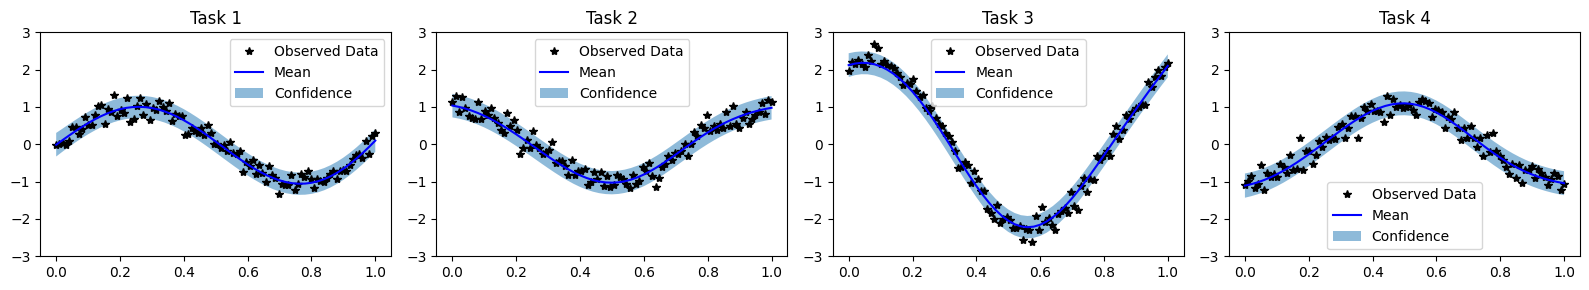

In [9]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
fig, axs = plt.subplots(1, num_tasks, figsize=(4 * num_tasks, 3))

# Make predictions
with torch.no_grad(), qpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
    
for task, ax in enumerate(axs):
    # Plot training data as black stars
    ax.plot(train_x.detach().numpy(), train_y[:, task].detach().numpy(), 'k*')
    # Predictive mean as blue line
    ax.plot(test_x.numpy(), mean[:, task].numpy(), 'b')
    # Shade in confidence 
    ax.fill_between(test_x.numpy(), lower[:, task].numpy(), upper[:, task].numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(f'Task {task + 1}')

fig.tight_layout()
None